# Assignment 6: PCA on MNIST

## Code Summary
The code aims to implement Principal Component Analysis (PCA) on the MNIST dataset. The primary objective is to reduce the dimensionality of the dataset while maintaining as much variability in the data as possible. Specifically, the PCA basis is computed using only the training dataset, but its quality is then evaluated on the test set.

In [24]:
# ------------------------------
# Import Required Libraries
# ------------------------------

# Standard Library
import random as rand
import math
from pathlib import Path
import requests
import pickle
import gzip

# Scientific Computing Libraries
import numpy as np
import scipy.optimize
import scipy.linalg as la
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint

# Data Visualization Library
import matplotlib.pyplot as plt

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [25]:
# --------------------------------------------------
# Install the MNIST Python Package if Necessary
# --------------------------------------------------
# To install the MNIST Python package, run the following command:
# pip install python-mnist

try:
    import mnist
except ImportError:
    import subprocess
    print("Installing the python-mnist package as it is not found...")
    subprocess.run(["pip", "install", "python-mnist"])
    import mnist

# Now the MNIST package should be available for use.

In [26]:
# ---------------------------------------------
# Load and Preprocess MNIST Dataset
# ---------------------------------------------

# Import Libraries for Linear Algebra and Optimization
import scipy.linalg as la
from scipy.optimize import LinearConstraint

# Import MNIST Library
from mnist import MNIST

# Load MNIST Data
mndata = MNIST("/Users/dadmehr/Codes/Python/Past/data/mnist/raw")
X_train, labels_train = map(np.array, mndata.load_training())
X_test, labels_test = map(np.array, mndata.load_testing())

# Preprocess Data: Normalize the features to [0, 1] range
X_train = X_train / 255.0
X_test = X_test / 255.0

# Calculating Mean and Covariance Matrix for MNIST Training Data

In [22]:
# Get the dimensions of the training data (n = number of samples, d = number of features)
n, d = X_train.shape

# ------------------------------
# Compute the Mean Vector (mu)
# ------------------------------
# Create an array of ones of shape (n,)
ones_array = np.ones(n)

# Calculate the mean of each feature (mu) using matrix multiplication
mu = np.matmul(X_train.T, ones_array) / n

# --------------------------------------
# Compute the Covariance Matrix (sigma)
# --------------------------------------
# Expand mean vector 'mu' to have the same shape as X_train
expanded_mu = np.outer(ones_array, mu)

# Calculate the covariance matrix using matrix multiplication
Big_Sig = ((X_train - expanded_mu).T @ (X_train - expanded_mu)) / n
sigma = Big_Sig

# ------------------------------------------------
# Compute Eigenvalues and Eigenvectors of sigma
# ------------------------------------------------
# Compute eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eig(Big_Sig)

# Remove the imaginary parts if they exist
# This is to ensure all numbers are real
eigvals = np.real(eigvals)
eigvecs = np.real(eigvecs)

# Reset mu to its earlier computed value (optional, as mu hasn't changed)
muu = mu

# The variables 'eigvals' and 'eigvecs' now contain the eigenvalues and eigenvectors of the covariance matrix


## Average = Mu

One point to note is that every estimation starts with the mean, often represented as 'mu'. So, when the value of 'k' is low, the image will closely resemble this average, or 'mu.' This means that the best initial guess for representing the image is simply the average of all images in the dataset. This is particularly useful when the goal is to minimize the message size for data transmission.

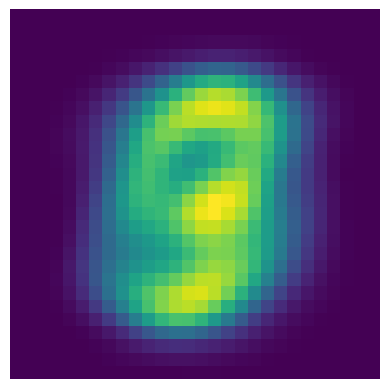

In [27]:
# Reshaping the Mean (Mu) to a 2D Array for Visualization
# In this case, the original image dimensions are assumed to be 28x28 pixels
x_shape = np.reshape(mu, (28, 28))

# Displaying the Reshaped Mean as an Image
plt.imshow(x_shape)

# Removing the Axes for a Cleaner Display
plt.axis('off')

# Showing the Image
plt.show()

# A6. a)

## Eigenvalue Analysis of the Sample Covariance Matrix

In [31]:
# Print the 1st largest eigenvalue
print('The 1st largest eigenvalue:', eigvals[0])  # Python indexing starts at 0

# Print the 2nd largest eigenvalue
print('The 2nd largest eigenvalue:', eigvals[1])

# Print the 10th largest eigenvalue
print('The 10th largest eigenvalue:', eigvals[9])  # 10 - 1 = 9

# Print the 30th largest eigenvalue
print('The 30th largest eigenvalue:', eigvals[29])  # 30 - 1 = 29

# Print the 50th largest eigenvalue
print('The 50th largest eigenvalue:', eigvals[49])  # 50 - 1 = 49

# Print the summation of all eigenvalues
print('The summation of all eigenvalues is:', sum(eigvals))

The 1st largest eigenvalue: 5.11678772834208
The 2nd largest eigenvalue: 3.741328478864824
The 10th largest eigenvalue: 1.2427293764173368
The 30th largest eigenvalue: 0.3642557202788903
The 50th largest eigenvalue: 0.16970842700672778
The summation of all eigenvalues is: 52.72503549512692


## Title: PCA Projection Using Top-k Eigenvalues and Eigenvectors

In [34]:
# Function to get the top-k eigenvectors
def k_eigvecs(k):
    """
    Returns the top-k eigenvectors from the global eigenvectors array.
    
    Parameters:
        k (int): The number of top eigenvectors to return.

    Returns:
        np.ndarray: Top-k eigenvectors.
    """
    return eigvecs[:, :k]

In [35]:
# Function to project a point x using PCA with top-k eigenvalues and eigenvectors
def new_PCA_project(x, k):
    """
    Projects a data point x to a lower-dimensional space using PCA.

    Parameters:
        x (np.ndarray): Original high-dimensional data point.
        k (int): The number of principal components to use for the projection.

    Returns:
        np.ndarray: Data point projected to the lower-dimensional space.
    """
    # Compute the projection using top-k eigenvectors and adding back the mean (muu)
    return muu + (x - muu) @ k_eigvecs(k) @ k_eigvecs(k).T

# e)

# Title: Visualizing PCA Reconstruction for Different Values of k
Note: The approximation improves as we include more eigenvectors.

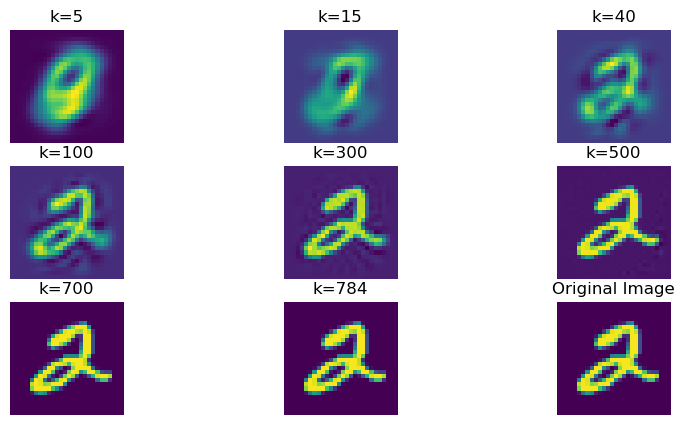

In [41]:
# Find the index of the first training example with label 2
j = np.where(labels_train == 2)[0][0]

# Create a figure to plot the PCA reconstructions
plt.figure(figsize=(10, 5), dpi=100)

# Initialize subplot counter
ii = 0

# List of 'k' values to be used for PCA reconstruction
k_values = [5, 15, 40, 100, 300, 500, 700, 28*28]

# Corresponding titles for each subplot
titles = ['k=5', 'k=15', 'k=40', 'k=100', 'k=300', 'k=500', 'k=700', 'k=784']

# Loop through each 'k' value to perform PCA reconstruction and plotting
for i in range(8):
    ii += 1
    plt.subplot(3, 3, ii)
    plt.title(titles[i])
    
    # Perform PCA reconstruction for the current 'k' value
    reconstructed_img = new_PCA_project(X_train[j], k_values[i])
    
    # Reshape the reconstructed image to its original shape and plot
    reshaped_img = np.reshape(reconstructed_img, (28, 28))
    plt.imshow(reshaped_img)
    plt.axis('off')

# Plot the original image for comparison
plt.subplot(3, 3, 9)
plt.title('Original Image')
original_img = np.reshape(X_train[j], (28, 28))
plt.imshow(original_img)
plt.axis('off')

# Show all plots
plt.show()

# Note: The approximation improves as we include more eigenvectors.

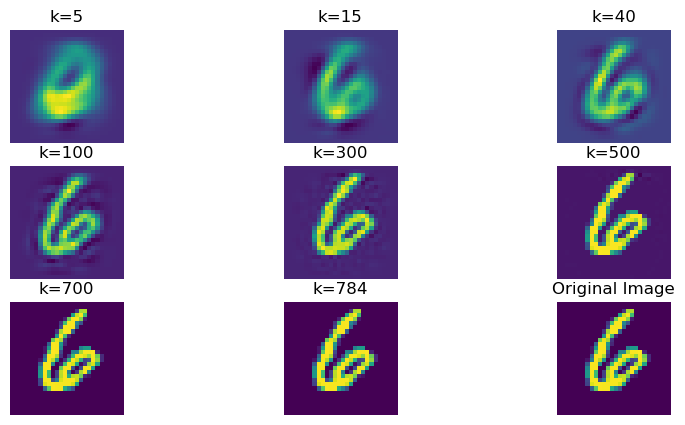

In [40]:
# Find the index of the first training example with label 6
j = np.where(labels_train == 6)[0][0]

# Create a figure to plot the PCA reconstructions
plt.figure(figsize=(10, 5), dpi=100)

# Initialize subplot counter
ii = 0

# List of 'k' values to be used for PCA reconstruction
k_values = [5, 15, 40, 100, 300, 500, 700, 28*28]

# Corresponding titles for each subplot
titles = ['k=5', 'k=15', 'k=40', 'k=100', 'k=300', 'k=500', 'k=700', 'k=784']

# Loop through each 'k' value to perform PCA reconstruction and plotting
for i in range(8):
    ii += 1
    plt.subplot(3, 3, ii)
    plt.title(titles[i])
    
    # Perform PCA reconstruction for the current 'k' value
    reconstructed_img = new_PCA_project(X_train[j], k_values[i])
    
    # Reshape the reconstructed image to its original shape and plot
    reshaped_img = np.reshape(reconstructed_img, (28, 28))
    plt.imshow(reshaped_img)
    plt.axis('off')

# Plot the original image for comparison
plt.subplot(3, 3, 9)
plt.title('Original Image')
original_img = np.reshape(X_train[j], (28, 28))
plt.imshow(original_img)
plt.axis('off')

# Show all plots
plt.show()

# Note: The approximation improves as we include more eigenvectors.

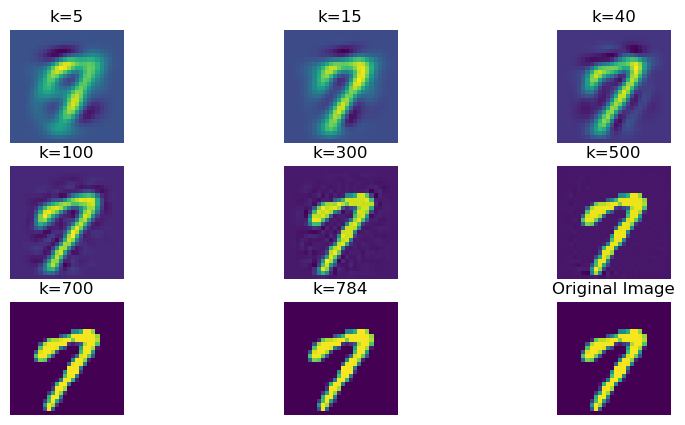

In [39]:
# Find the index of the first training example with label 7
j = np.where(labels_train == 7)[0][0]

# Create a figure to plot the PCA reconstructions
plt.figure(figsize=(10, 5), dpi=100)

# Initialize subplot counter
ii = 0

# List of 'k' values to be used for PCA reconstruction
k_values = [5, 15, 40, 100, 300, 500, 700, 28*28]

# Corresponding titles for each subplot
titles = ['k=5', 'k=15', 'k=40', 'k=100', 'k=300', 'k=500', 'k=700', 'k=784']

# Loop through each 'k' value to perform PCA reconstruction and plotting
for i in range(8):
    ii += 1
    plt.subplot(3, 3, ii)
    plt.title(titles[i])
    
    # Perform PCA reconstruction for the current 'k' value
    reconstructed_img = new_PCA_project(X_train[j], k_values[i])
    
    # Reshape the reconstructed image to its original shape and plot
    reshaped_img = np.reshape(reconstructed_img, (28, 28))
    plt.imshow(reshaped_img)
    plt.axis('off')

# Plot the original image for comparison
plt.subplot(3, 3, 9)
plt.title('Original Image')
original_img = np.reshape(X_train[j], (28, 28))
plt.imshow(original_img)
plt.axis('off')

# Show all plots
plt.show()

# Note: The approximation improves as we include more eigenvectors.

## Title: Function to Calculate Reconstruction Error for PCA

In [42]:
def reconstruction_error(k):
    """
    Calculate the mean squared error in the PCA reconstruction 
    of training and testing data for a given 'k' eigenvectors.
    
    Parameters:
        k (int): The number of eigenvectors to use for PCA.
        
    Returns:
        tuple: Mean squared error for training and testing data.
    """
    
    # Initialize counter and error variables for training data
    n = 1
    train_error = 0
    
    # Calculate the number of training samples to process
    n1 = int(np.shape(X_train)[0] / n)
    
    # Loop through training samples to accumulate the squared error
    for i in range(n1):
        train_error += np.linalg.norm(new_PCA_project(X_train[i], k) - X_train[i])**2
    
    # Initialize error variable for testing data
    test_error = 0
    
    # Calculate the number of testing samples to process
    n2 = int(np.shape(X_test)[0] / n)
    
    # Loop through testing samples to accumulate the squared error
    for i in range(n2):
        test_error += np.linalg.norm(new_PCA_project(X_test[i], k) - X_test[i])**2
    
    # Return the mean squared errors for training and testing data
    return train_error / n1, test_error / n2

# Note: The function can be used to evaluate the quality of PCA basis by calculating the reconstruction error.

In [15]:
reconstruction_error(10)

(52.66800352142155, 52.84524106822601)

In [16]:
reconstruction_error(1)

(52.70193547889742, 52.87343386035088)

The reconstruction_error function calculates the mean squared error (MSE) for PCA reconstructions on both the training and test datasets. It takes the number of eigenvectors k to be used in the PCA approximation as an argument. The function returns two values: the MSE for the training dataset and the MSE for the test dataset. Lower MSE values indicate better approximations of the original data.

# A6. c)

## Title: Analyzing PCA Variance and Reconstruction Error

In [17]:
# Initialize the number of different 'k' values to consider
n = 100

# Create arrays to store the k values, the proportion of unexplained variance,
# and the reconstruction errors for training and test sets
pca_k_range = list(range(0, n))
pca_y = np.zeros(n)
train_e = np.zeros(n)
test_e = np.zeros(n)

# Loop over each 'k' value from 0 to n-1
for i in range(n):
    # Calculate and store the proportion of total variance not explained
    # by the first 'i' principal components
    pca_y[i] = 1 - sum(eigvals[:i]) / sum(eigvals)
    
    # Calculate and store the reconstruction error (Mean Squared Error)
    # for both the training and test datasets using 'i' principal components
    train_e[i], test_e[i] = reconstruction_error(pca_k_range[i])

# pca_y now contains the proportion of unexplained variance for each 'k'
# train_e and test_e contain the reconstruction errors for training and test sets


### Plotting Reconstruction Error for Training and Test Sets

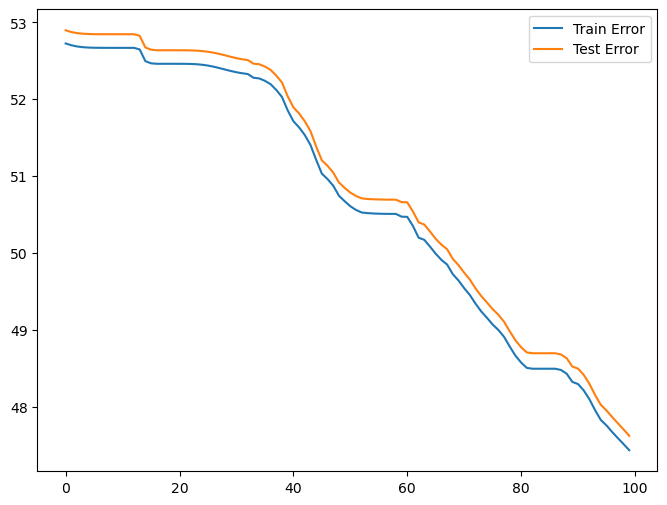

In [44]:
# Create a plot to visualize the reconstruction error
plt.figure(figsize=(8, 6), dpi=100)

# Uncomment the following line to plot the proportion of unexplained variance
# plt.plot(pca_k_range, pca_y)

# Plot the reconstruction error (Mean Squared Error) for the training set
plt.plot(pca_k_range, train_e, label='Train Error')

# Plot the reconstruction error (Mean Squared Error) for the test set
plt.plot(pca_k_range, test_e, label='Test Error')

# Add a legend to differentiate the curves
plt.legend(loc="best")

# Display the plot
plt.show()

### Title: Plotting Proportion of Unexplained Variance Over PCA Components

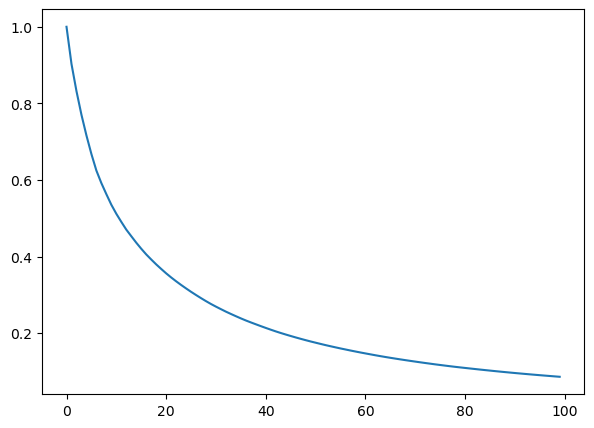

In [45]:
# Create a plot to visualize the proportion of unexplained variance
plt.figure(figsize=(7, 5), dpi=100)

# Plot the proportion of unexplained variance for different numbers of PCA components (k)
plt.plot(pca_k_range, pca_y)

# Uncomment the following line to add a legend if necessary
# plt.legend(loc="best")

# Display the plot
plt.show()

# A6. d) Displaying the First 10 Eigenvectors as Images

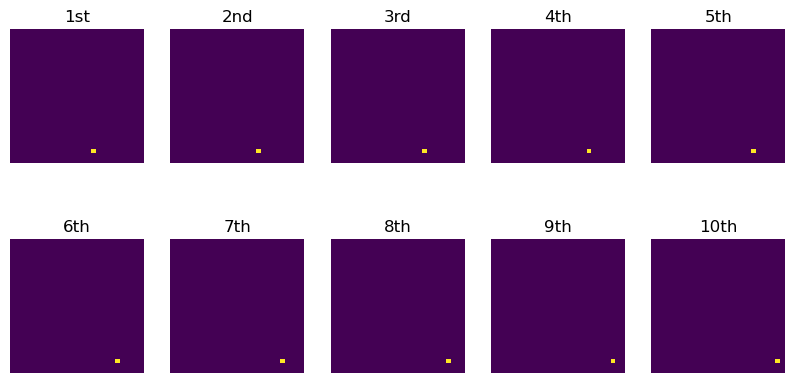

In [47]:
# Create a figure to display the first 10 eigenvectors
plt.figure(figsize=(10, 5), dpi=100)

# Initialize an index counter
ii = 0

# Define the text labels for each subplot
text_labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th']

# Loop through the first 10 eigenvectors to display them
for i in range(10):
    ii += 1
    
    # Create a subplot for each eigenvector
    plt.subplot(2, 5, ii)
    
    # Add a title to each subplot
    plt.title(text_labels[i])
    
    # Reshape the eigenvector to 28x28 for visualization
    eigenvector_image = np.reshape(eigvecs[ii - 1], (28, 28))
    
    # Display the eigenvector as an image
    plt.imshow(eigenvector_image)
    
    # Hide axis labels and ticks
    plt.axis('off')

# Show the figure
plt.show()